In [1]:
import imageio
import numpy as np
from functions import *
from PIL import Image

from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

import timeit

%load_ext autoreload
%autoreload 2
% matplotlib inline

In [69]:
# infolder = 'positive_images'
# outfolder = 'positive_images_resized'
# images = os.listdir(infolder)
# for img in images[:5000]:
#     in_img = os.path.join(infolder, img)
#     im = Image.open(in_img)
#     im.thumbnail((500,500), Image.ANTIALIAS)
#     out_img = os.path.join(outfolder, img)
#     im.save(out_img, "JPEG")

In [2]:
def train(X, Y, model, loss_fn, optimizer, batch_size=16, num_iters=1, print_every=10):
    N = len(Y)
    for it in range(num_iters):
        # print('Starting iter %d / %d' % (it + 1, num_iters))
        
        # Grab Batches
        indicies = np.random.choice(np.arange(N), size=batch_size)
        X_batch = X[indicies]
        Y_batch = Y[indicies]
        
        X_var = Variable(X_batch)
        Y_var = Variable(Y_batch)

        scores = model(X_var)
        loss = loss_fn(scores, Y_var)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (it % print_every == 0):
            print('loss: ', loss.item())

# This is a little utility that we'll use to reset the model
# if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()
        
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

# Hand Classification

In [3]:
# Read Some Images
X, Y, Joints, Hand_Info = read_img_data(5000, print_every=500)

Loading Positive Image:  0
Loading Positive Image:  500
Loading Positive Image:  1000
Loading Positive Image:  1500
Loading Positive Image:  2000
Loading Negative Image:  0
Loading Negative Image:  500
Loading Negative Image:  1000
Loading Negative Image:  1500
Loading Negative Image:  2000


In [4]:
dtype = torch.FloatTensor

X_train, X_test, X_val, Y_val, Y_train, Y_test = split(X, Y, 5000)
X_train = torch.from_numpy(to_channels_first(X_train)).type(dtype)
X_test = torch.from_numpy(to_channels_first(X_test)).type(dtype)
Y_train = torch.from_numpy(Y_train).type(dtype).unsqueeze(1)
Y_test = torch.from_numpy(Y_test).type(dtype).unsqueeze(1)
print(X_train.size())
print(Y_train.size())

torch.Size([3200, 3, 100, 100])
torch.Size([3200, 1])


In [6]:
model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=5, stride=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        nn.Conv2d(32, 64, kernel_size=5, stride=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    
        nn.Conv2d(64, 64, kernel_size=3, stride=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    
        nn.Conv2d(64, 32, kernel_size=3, stride=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    
        Flatten(),
        nn.Linear(512,1),
        nn.Sigmoid()
    
).type(dtype)

loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train(X_train, Y_train, model, loss_fn, optimizer, num_iters=30, print_every=5)

loss:  0.7990717887878418
loss:  0.36730363965034485
loss:  0.05783544108271599
loss:  0.00433340622112155
loss:  0.06463585048913956
loss:  0.00016239735123235732


In [ ]:
preds_train = model(X_train)
preds_test = model(X_test)

In [73]:
n_correct = (preds_train.round()==Y_train).sum().item()
print('Training Accuracy: ', n_correct / X_train.shape[0])
n_correct = (preds_test.round()==Y_test).sum().item()
print('Test Accuracy: ', n_correct / X_test.shape[0])

Training Accuracy:  1.0
Test Accuracy:  1.0


# Generating Labels Bounding Box

In [74]:
labels = gen_labels(Y, Joints)

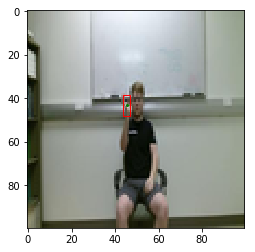

In [75]:
idx = 200
plot_bounding_box_from_grid(X[idx], labels[idx])

In [76]:
print(labels[idx][2,1])
print(Y[idx])
print(Hand_Info[idx])

[ 0.  0.  0.  0.  0.]
1.0
1.0


# PyTorch

In [5]:
labels = gen_labels(Y, Joints, grid_size=1)
Y_rolled = np.rollaxis(labels, 3, 1)
X_rolled = to_channels_first(X)
print('Y_rolled shape: ', Y_rolled.shape)
print('X_rolled shape: ', X_rolled.shape)

Y_train = torch.from_numpy(Y_rolled).type(dtype)
X_train = torch.from_numpy(X_rolled).type(dtype)
print(X_train.size())
print(Y_train.size())

Y_rolled shape:  (100, 5, 1, 1)
X_rolled shape:  (100, 3, 100, 100)


In [37]:
def yolo_loss():
#     return nn.MSELoss().type(dtype)
    def loss(Output, Y):
        N = Y.shape[0]
        grid_size = Y.shape[2]
        print('grid size', grid_size)
        loss = 0.
        c = 0
        for out, y in (zip(Output, Y)):
            for i in range(grid_size):
                for j in range(grid_size):
                    if abs(y[0,i,j] - 1) < 0.01:
                        c += 1
                        bce_loss = nn.BCELoss()
                        loss = loss + bce_loss(torch.sigmoid(out[0,i,j]), y[0,i,j])
                        loss = loss + ((out[1:5,i,j] - y[1:5,i,j])**2).sum()
                    else:
                        bce_loss = nn.BCELoss()
                        loss = loss + bce_loss(torch.sigmoid(out[0,i,j]), y[0,i,j])
                        # loss = loss + (out[0,i,j] - y[0,i,j])**2  # loss computed on only p_c
        print('positves', c)
        return loss / N
    
    return loss

In [79]:
yolo_model = nn.Sequential(
        nn.Conv2d(3, 8, kernel_size=5, stride=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        nn.Conv2d(8, 16, kernel_size=5, stride=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    
        nn.Conv2d(16, 16, kernel_size=3, stride=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    
        nn.Conv2d(16, 16, kernel_size=3, stride=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    
        nn.Conv2d(16, 8, kernel_size=2, stride=1),
        nn.ReLU(inplace=True),
        
        nn.Conv2d(8, 5, kernel_size=3, stride=1),
        nn.ReLU(inplace=True)
    )

loss_fn = nn.MSELoss().type(dtype)
optimizer = optim.Adam(yolo_model.parameters(), lr=1e-3)
train(X_train, Y_train, yolo_model, loss_fn, optimizer, num_iters=10, print_every=1)

RuntimeError: input and target shapes do not match: input [16 x 5 x 1 x 1], target [16 x 1] at /Users/soumith/code/builder/wheel/pytorch-src/aten/src/THNN/generic/MSECriterion.c:13

In [39]:
preds = fixed_model(X_train)

In [40]:
preds[:5]

tensor([[[[ 0.8435]],

         [[ 0.5194]],

         [[ 0.0000]],

         [[ 0.0000]],

         [[ 0.0000]]],


        [[[ 0.8399]],

         [[ 0.5286]],

         [[ 0.0000]],

         [[ 0.0000]],

         [[ 0.0000]]],


        [[[ 0.8167]],

         [[ 0.5588]],

         [[ 0.0000]],

         [[ 0.0000]],

         [[ 0.0000]]],


        [[[ 0.8613]],

         [[ 0.5418]],

         [[ 0.0000]],

         [[ 0.0000]],

         [[ 0.0000]]],


        [[[ 0.8688]],

         [[ 0.5376]],

         [[ 0.0000]],

         [[ 0.0000]],

         [[ 0.0000]]]])

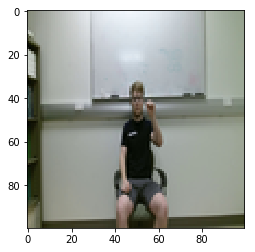

In [359]:
plt.imshow(X[4].astype('uint8'))

In [253]:
l = 0.
l = l + (output[0][:5,1,1] - Y_train[0][:5,1,1]).sum()**2
l

tensor(9.9404)

In [255]:
l = 0.
l = l + (output[0][0,1,1] - Y_train[0][0,1,1])**2
l

tensor(1.)

In [273]:
loss_fn = nn.MSELoss().type(dtype)
print(output[0][:][0][0])
print(Y_train[0][:][0][0])
print(Y_train[0][0])
print(Y_train[0][:5,1,1])
print(output[0][:5,1,1])
loss_fn(output[0][:5,1,1], Y_train[0][:5,1,1])

tensor([ 0.,  0.,  0.])
tensor([ 0.,  0.,  0.])
tensor([[ 0.,  0.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  0.]])
tensor([ 1.0000,  0.5622,  0.4269,  0.1222,  0.0651])
tensor([ 0.,  0.,  0.,  0.,  0.])


tensor(0.3035)

In [242]:
(output[0][:5,1,1] - Y_train[0][:5,1,1])

tensor([-1.0000, -0.5622, -0.4269, -0.1222, -0.0651])

In [274]:
((output[0][:5,1,1] - Y_train[0][:5,1,1])**2).sum()

tensor(1.5175)

In [234]:
Y_train[0]

tensor([[[ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  1.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.5622,  0.0000],
         [ 0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.4269,  0.0000],
         [ 0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.1222,  0.0000],
         [ 0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0651,  0.0000],
         [ 0.0000,  0.0000,  0.0000]]])

In [191]:
train(X_train, Y_train, fixed_model, loss_fn, optimizer, num_epochs=10)

Starting epoch 1 / 10
loss:  tensor(1.00000e-02 *
       2.8054)
Starting epoch 2 / 10
loss:  tensor(1.00000e-02 *
       2.8054)
Starting epoch 3 / 10
loss:  tensor(1.00000e-02 *
       2.8054)
Starting epoch 4 / 10
loss:  tensor(1.00000e-02 *
       2.8054)
Starting epoch 5 / 10
loss:  tensor(1.00000e-02 *
       2.8054)
Starting epoch 6 / 10
loss:  tensor(1.00000e-02 *
       2.8054)
Starting epoch 7 / 10
loss:  tensor(1.00000e-02 *
       2.8054)
Starting epoch 8 / 10
loss:  tensor(1.00000e-02 *
       2.8054)
Starting epoch 9 / 10
loss:  tensor(1.00000e-02 *
       2.8054)
Starting epoch 10 / 10
loss:  tensor(1.00000e-02 *
       2.8054)


In [178]:
print(fixed_model)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU(inplace)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU(inplace)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU(inplace)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (10): ReLU(inplace)
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(16, 5, kernel_size=(2, 2), stride=(1, 1))
  (13): ReLU(inplace)
)


In [154]:
train(fixed_model, loss_fn, optimizer)

Starting epoch 1 / 1


RuntimeError: expected stride to be a single integer value or a list of 3 values to match the convolution dimensions, but got stride=[1, 1]

In [100]:
x = torch.randn(3, requires_grad=True)

y = x * 2
while y.data.norm() < 1000:
    y = y * 2

print(y)
z = y + 2

tensor([ -150.7955, -1412.2751,   698.5419])


In [102]:
gradients = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float)
z.backward(gradients)

print(x.grad)

tensor([  204.8000,  2048.0000,     0.2048])


In [103]:
x.grad

tensor([  204.8000,  2048.0000,     0.2048])

In [106]:
y.requires_grad

True

In [109]:
x = torch.randn(1, requires_grad=True)
y = x + 2
z = y * 3

z.backward()

In [111]:
x.grad

tensor([ 3.])